In [2]:
!pip install metpy

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import pandas as pd

### compute heavy rainfall ratio for LaNina


#### get data 

In [3]:
%%time 
##----------------------------------------------------
## 20CR apcp, only for 1950-2014, tropical australia
##----------------------------------------------------
filelist=[]
for i in range(1950,2015,1):
    filelist.append(f'/Users/dongxiay/Documents/data/daily/apcp.{i}.nc')
ds1=xr.open_mfdataset(filelist,combine='by_coords')
ds=ds1['apcp'].loc[:,-45:0,100:160]

##----------------------------------------------------
##OT12 MJO, if amplitude <1, make phase =0
##----------------------------------------------------
df=pd.read_csv("/Users/dongxiay/Documents/data/MJO_ot12.csv")
df['time']=pd.to_datetime(df[['year','month','day']])
df=df.set_index('time').drop(columns=['year','month','day'])
df.loc[df['amplitude'].lt(1) ,'phase'] = 0

##----------------------------------------------------
##NINO3.4, monthly resample to daily, nino34>1 elnino, nino34<-1 lanina, else neatural
##----------------------------------------------------
nino=pd.read_csv("https://psl.noaa.gov/data/correlation/nina34.anom.data",
                sep='  ', skiprows=3,skipfooter=4,names=np.arange(1,13))
nino=nino.reset_index()
nino_long = pd.melt(nino,id_vars='index')
nino_long = nino_long.rename(columns={'index':'year','variable':'month'})
nino_long['day'] = 1
nino_long['time'] = pd.to_datetime(nino_long[['year','month','day']])
nino_long = nino_long[['time','value']]
nino_long = nino_long.set_index('time').resample('1d').ffill()

nino_long.loc[nino_long['value']<(-1) ,'watch'] = -1
nino_long.loc[nino_long['value']>(1) ,'watch'] = 1
nino_long.loc[(nino_long['value']>(-1)) & (nino_long['value']<(1)),'watch']=0

df2=nino_long

##merge
dfmjo=df.loc[(df.index >= ds.time.min().values) & (df.index <= ds.time.max().values)][['amplitude','phase']]
dfenso=df2.loc[(df2.index >= ds.time.min().values) & (df2.index <= ds.time.max().values)]['watch']
data_org=xr.merge([ds,dfmjo.to_xarray(),dfenso.to_xarray()],join='inner').load()

/Users/dongxiay/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


CPU times: user 26.3 s, sys: 1.08 s, total: 27.4 s
Wall time: 28.5 s


####  Ratio=Result/baseline for Lanina
Result= (number of days when rainfall exceeding the 90% threshold (THR) for MJO phase 1) / (number of days that is in MJO phase 1)

baseline= (number of days when rainfall exceeding the THR) / (total days for all Lanina days)

In [4]:
##only select wet season NOV-APR
data_org = data_org.sel(time=data_org.time.dt.month.isin([1, 2, 3, 4, 11, 12]))

In [5]:
datanino = data_org['apcp'].loc[data_org.watch== -1]
phasenino= data_org['phase'].loc[data_org.watch== -1]

def func(ds):
    return ds.count('time') / len(ds['time'])

THR=0.90
THR_threshold = datanino.where(datanino!=0).chunk(dict(time=-1)).quantile(THR, dim='time')

baseline = datanino.where(datanino >= THR_threshold).count('time') / len(datanino['time'])
baseline=baseline.compute()

result = datanino.where(datanino >= THR_threshold).groupby(phasenino).apply(func).compute()
ratio= result/baseline
obs=ratio


data=obs.loc[1:,-23.5:-10,110:160]


#### average over latitude

In [6]:
# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(data.lat.values))
avg_data = (data * weights[None, :, None]).sum(dim='lat') / np.sum(weights)
lons = data.lon.values
phases=data.phase.values

Text(0.0, 1.0, 'heavy rainfall ratio /LaNina')

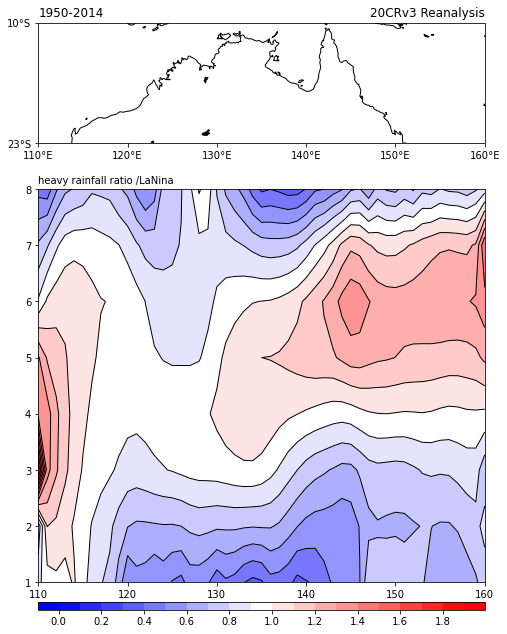

In [8]:
# Start figure
fig = plt.figure(figsize=(8,12))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 4], hspace=0.15)

# Tick labels
x_tick_labels = [u'110\N{DEGREE SIGN}E', u'120\N{DEGREE SIGN}E',
                 u'130\N{DEGREE SIGN}E', u'140\N{DEGREE SIGN}E',
                 u'150\N{DEGREE SIGN}E', u'160\N{DEGREE SIGN}E']

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
ax1.set_extent([110,160, -23.5, -10], ccrs.PlateCarree(central_longitude=0))
ax1.set_yticks([-23.5, -10])
ax1.set_yticklabels([u'23\N{DEGREE SIGN}S', u'10\N{DEGREE SIGN}S'])
ax1.set_xticks([110,120,130,140,150,160])
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)

# Set some titles
plt.title('1950-2014', loc='left')
plt.title('20CRv3 Reanalysis', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
# ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
# clevs = np.arange(0.45, 1.65, 0.15)
clevs = np.arange(0,2,0.1)
cf = ax2.contourf(lons, phases, mpcalc.smooth_n_point(
    avg_data, 9, 2), 
                  clevs,
                  cmap=plt.cm.bwr, extend='both')
cs = ax2.contour(lons, phases, mpcalc.smooth_n_point(
    avg_data, 9, 2), 
                 clevs, 
                 colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
#cbar.set_label('m $s^{-1}$')

# Make some ticks and tick labels
# ax2.set_xticks([0, 90, 180, 270, 357.5])
# ax2.set_xticklabels(x_tick_labels)
# ax2.set_yticks(vtimes[4::8])
# ax2.set_yticklabels(vtimes[4::8])

# Set some titles
plt.title('heavy rainfall ratio /LaNina', loc='left', fontsize=10)
